In [1]:
import openai
import config  # Import your config.py file
import pandas as pd
import numpy as np
import pickle
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import time
from datetime import datetime, timedelta
import re
from call_gpt_helpers import get_embedding, get_model_response, identify_gics_classes, RateLimiter, load_pickle_file
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity

##
## the three imports below are used for the cross validation model to allow us the "zero-shot"/"self-supervised" model
##
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
# Set up the OpenAI API key from the config.py file
openai.api_key = config.api_key 

In [2]:

system_message = f"""You are an expert in tGlobal Industry Classification Standard (GICS) industry classes. Read the dictionary of gics classes (gics_dict) 
    surrounded by triple colons 
    :::countries_dict:::
    
    The user will supply you with a biography. using this information you must reason through the most, likely gics classes the list. 
    The return string should be in the form shown below and should contain at least 1 entry
    [entry_1, entry_2,.. entry_n]
    
    """

#prompt = f"""{biography}
#            """

    
path_folder = './data/cities_json/London'

In [3]:
all_files = os.listdir(path_folder)

In [4]:
data_root = './data/cities_json'
bios_path = './data/all_bios_embeddings.csv'
missing_bios_path = './data/missing_bios.csv'
if os.path.exists(bios_path):
    # Load the existing CSV if it exists
    all_bios_df = pd.read_csv(bios_path)
    #this conversion takes about 10 secs. a better storage method may be preferable aka, index = file name columns are numeric embeddings
    all_bios_df['embedding'] = all_bios_df['embedding'].apply(ast.literal_eval)
    missing_bio_df = pd.read_csv(missing_bios_path)
else:
    # Run the code to generate DataFrames a and b
    all_bios_df = []
    for path in os.listdir(data_root ):

        all_files = os.listdir(data_root +'/' + path)

        for file in all_files:

            temp_dict = load_pickle_file(data_root +'/' + path +'/'+file)

            if 'biography' not in temp_dict:
                temp_dict['biography'] = pd.DataFrame({'Biography':[""]})
            
            temp_df = temp_dict['biography']
            temp_df['city'] = path
            temp_df['file'] = file
            temp_df['file'] = temp_df['file'].replace('.pkl', "")

            all_bios_df.append(temp_df)


    all_bios_df = pd.concat(all_bios_df, ignore_index=True)
    all_bios_df = all_bios_df[['file', 'city','Biography']]

    all_bios_df['no_bio']=(all_bios_df['Biography'].apply(len)<50)
    missing_bio_df = all_bios_df.loc[all_bios_df['no_bio'] ].copy().drop('no_bio', axis = 1)

    all_bios_df = all_bios_df.loc[~all_bios_df['no_bio'] ].drop('no_bio', axis = 1)

    #this takes about 12 minutes and costs money, only run when necessary!!!
    all_bios_df['embedding'] = all_bios_df['Biography'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

    missing_bio_df.to_csv(missing_bios_path, index = False)
    all_bios_df.to_csv(bios_path, index = False)


In [5]:
all_files = pd.concat([all_bios_df.groupby(['city']).size(), missing_bio_df.groupby(['city']).size()], axis=1).rename(columns = {0:'gics_class', 1:'no_gics'})


all_files['all_files'] = all_files.sum(axis = 1)

all_files

,gics_class,no_gics,all_files
city,,,
Frankfurt,103,229.0,332.0
Hong Kong,384,14.0,398.0
Johannesburg,124,2.0,126.0
Lagos,246,25.0,271.0
London,394,6.0,400.0
Mexico City,104,3.0,107.0
New York,389,11.0,400.0
Rio de Janeiro,52,NaN,52.0
San Francisco Bay Area,390,9.0,399.0


In [6]:
gics_embeddings_path = './data/gics_embeddings.csv'
if os.path.exists(gics_embeddings_path):
    # Load the existing CSV if it exists
    gics_embeddings_df = pd.read_csv(gics_embeddings_path)
    gics_embeddings_df['embedding'] = gics_embeddings_df['embedding'].apply(ast.literal_eval)

else:
    gics_embeddings_df = pd.read_csv('./data/gics-map-2018.csv')
    gics_embeddings_df['embedding_desc'] = gics_embeddings_df['SubIndustryDescription'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    gics_embeddings_df['embedding'] = gics_embeddings_df['SubIndustry'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    gics_embeddings_df['token_count'] = gics_embeddings_df['SubIndustryDescription'].apply(lambda x: len(encoding.encode(x)))
    gics_embeddings_df.to_csv(gics_embeddings_path, index=False)



# Perform auto classification of the gics classes

In [7]:
gics_embeddings_df['Sector'].unique()

array(['Energy', 'Materials', 'Industrials', 'Consumer Discretionary',
       'Consumer Staples', 'Health Care', 'Financials',
       'Information Technology', 'Communication Services', 'Utilities',
       'Real Estate'], dtype=object)

In [8]:

#prevents the calls to gpt being re-run unnecessarily
if 'classes' not in all_bios_df.columns:
    all_bios_df = identify_gics_classes(all_bios_df, str(gics_embeddings_df['Industry'].unique().tolist()), 
                                        system_message = "You are an expert in classifying biographies into gics classes", rate_limit=80000, save_path='./data/temp_gics_classes.csv')
    all_bios_df.to_csv(bios_path, index = False)


# Create a binary multi-label dataframe

In [9]:
binary_data = {}

# Iterate through each class in the original list and construct the binary data
for class_name in gics_embeddings_df['Industry'].unique().tolist():
    binary_data[class_name] = all_bios_df['classes'].apply(lambda x: 1 if class_name in x else 0)

binary_df = pd.DataFrame(binary_data)
binary_df['city'] = all_bios_df['city'].str.replace(' Bay Area', "")


binary_data_industry = binary_data.copy()


In [10]:
#aggregate to sector level

tax_df = gics_embeddings_df.loc[:, ['Sector','Industry']]
df = binary_df.copy()

# Create a mapping from Industry to Sector
mapping = tax_df.set_index('Industry')['Sector'].to_dict()

# Use the mapping to sum columns belonging to the same sector
result = pd.DataFrame(index=df.index)
for sector, group in df.groupby(mapping, axis=1):
    result[sector] = group.sum(axis=1)

    
binary_df = (result>0)*1
binary_df['city'] = all_bios_df['city'].str.replace(' Bay Area', "")


In [11]:
#entropy(row)

def compute_entropies(num_classes):
    # Probabilities for maximum entropy (all classes equally likely)
    probs_max_entropy = [1/num_classes] * num_classes
    
    # Probabilities for minimum entropy (one class certain, all others impossible)
    probs_min_entropy = [1] + [0] * (num_classes - 1)
    
    max_entropy = entropy(probs_max_entropy, base=2)
    min_entropy = entropy(probs_min_entropy, base=2)
    
    return max_entropy, min_entropy

# Test the function
N = 11  # For example
max_entropy, min_entropy = compute_entropies(N)
print(f"Maximum entropy for {N} classes: {max_entropy:.4f}")
print(f"Minimum entropy for {N} classes: {min_entropy:.4f}")

2/3.4594



Maximum entropy for 11 classes: 3.4594
Minimum entropy for 11 classes: 0.0000


0.5781349366942244

In [12]:
binary_data_industry = pd.DataFrame(binary_data_industry)#
binary_data_industry['city'] = all_bios_df['city'].str.replace(' Bay Area', "")
binary_data_industry = binary_data_industry.groupby('city').sum()
binary_data_industry = binary_data_industry.div(binary_data_industry.sum(axis = 1), axis = 0)

binary_data_industry.groupby('city').sum().T

city,Frankfurt,Hong Kong,Johannesburg,Lagos,London,Mexico City,New York,Rio de Janeiro,San Francisco,Sydney
Energy Equipment & Services,0.005,0.005439,0.002688,0.043367,0.009517,0.002841,0.002812,0.008065,0.000809,0.007194
"Oil, Gas & Consumable Fuels",0.000,0.010878,0.005376,0.089286,0.040996,0.011364,0.014058,0.048387,0.004854,0.021583
Chemicals,0.025,0.010101,0.000000,0.014031,0.014641,0.031250,0.006560,0.032258,0.004045,0.007194
Construction Materials,0.005,0.007770,0.005376,0.008929,0.005857,0.014205,0.004686,0.000000,0.000809,0.000000
Containers & Packaging,0.010,0.012432,0.008065,0.007653,0.008785,0.005682,0.005623,0.008065,0.000000,0.007194
...,...,...,...,...,...,...,...,...,...,...
Multi-Utilities,0.000,0.004662,0.000000,0.003827,0.000732,0.002841,0.000937,0.000000,0.000000,0.000000
Water Utilities,0.000,0.001554,0.000000,0.002551,0.002196,0.000000,0.000000,0.000000,0.000000,0.000000
Independent Power and Renewable Electricity Producers,0.000,0.000000,0.000000,0.000000,0.000000,0.002841,0.000000,0.000000,0.000000,0.000000
Equity Real Estate Investment Trusts (REITs),0.000,0.002331,0.002688,0.001276,0.000732,0.000000,0.003749,0.000000,0.000809,0.000000


In [13]:
pd.merge(tax_df, binary_data_industry.groupby('city').sum().T.reset_index(), 
         left_on='Industry', right_on='index').sort_values(['Sector', 'Industry']).to_csv('./data/gics_distrib_industry.csv')

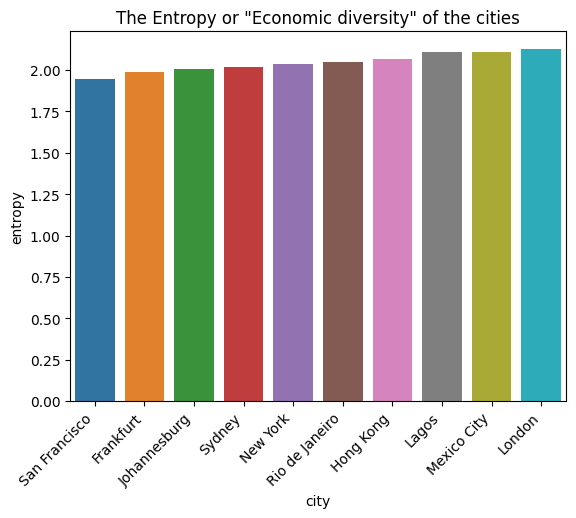

In [14]:
binary_df

gics_totals = binary_df.groupby('city').sum()

gics_distrib = gics_totals.div(gics_totals.sum(axis = 1), axis = 0)

gics_distrib 


gics_entropy_values = gics_distrib.apply(lambda row: entropy(row), axis=1)
gics_entropy_values =  gics_entropy_values.sort_values().reset_index().rename(columns = {0:'entropy'})

sns.barplot(data = gics_entropy_values, x = 'city', y = 'entropy')
plt.title('The Entropy or "Economic diversity" of the cities')
plt.xticks(rotation=45, ha='right', va='top')
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


# 1. Create a TF-IDF matrix from the string column
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_bios_df['Biography'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())


# Get top n terms based on their average importance across all documents
n = 100
top_n_terms = tfidf_df.mean().nlargest(n).index
reduced_tfidf_df = tfidf_df[top_n_terms]

print(reduced_tfidf_df )

           the        in       and        of        as        he        to  \
0     0.076153  0.000000  0.000000  0.074142  0.078606  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.047097  0.000000  0.000000  0.000000   
2     0.197969  0.081446  0.079719  0.089946  0.040869  0.000000  0.042779   
3     0.227488  0.037436  0.128249  0.203763  0.093926  0.054057  0.039327   
4     0.277628  0.129795  0.152451  0.135149  0.065130  0.014994  0.068174   
...        ...       ...       ...       ...       ...       ...       ...   
2237  0.071270  0.094246  0.040999  0.099125  0.073565  0.084677  0.033002   
2238  0.026152  0.107592  0.171130  0.063654  0.040492  0.031072  0.042384   
2239  0.000000  0.000000  0.000000  0.167137  0.088599  0.000000  0.000000   
2240  0.074783  0.115374  0.050190  0.036404  0.012865  0.029617  0.013467   
2241  0.106079  0.109105  0.061024  0.073770  0.109496  0.108031  0.016373   

       company        at      from  ...      have  million  fin

In [16]:
from sklearn.decomposition import TruncatedSVD

# Number of topics/concepts you want to retain
num_topics = 100

# Create LSA model using sklearn's TruncatedSVD
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Convert topic matrix to DataFrame for better view
lsa_df = pd.DataFrame(lsa_topic_matrix, columns=[f"Topic_{i}" for i in range(1, num_topics+1)])

print(lsa_df)

       Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7  \
0     0.090548 -0.031821 -0.006288 -0.003819 -0.043746  0.041647 -0.032379   
1     0.022597  0.010850  0.001294  0.011252 -0.013546  0.013554 -0.018816   
2     0.266372 -0.015384  0.052638 -0.007031  0.099308  0.051050 -0.045534   
3     0.370053 -0.035379  0.005266  0.010169 -0.046210  0.073361 -0.080184   
4     0.426157 -0.029425  0.028343  0.024061  0.040097  0.068363 -0.045499   
...        ...       ...       ...       ...       ...       ...       ...   
2237  0.209650 -0.013783 -0.021387  0.003463 -0.032803 -0.010923  0.015868   
2238  0.239606 -0.017009 -0.019597  0.099618  0.023211  0.054588  0.130742   
2239  0.107001  0.003702 -0.009348  0.046261 -0.067606  0.048834 -0.033725   
2240  0.206436  0.011221  0.007671  0.020704  0.074247  0.014615  0.046578   
2241  0.260318 -0.040769 -0.037423 -0.012858 -0.051107 -0.011197  0.024577   

       Topic_8   Topic_9  Topic_10  ...  Topic_91  Topic_92  To

In [17]:
!pip install umap

In [109]:
import umap
df = pd.DataFrame(all_bios_df['embedding'].to_list())
tsne = umap.UMAP(n_components=2, random_state=42)

# Apply t-SNE to the dataframe
tsne_result = umap_model.fit_transform(df)

AttributeError: module 'umap' has no attribute 'UMAP'

In [98]:
X = lsa_df# pd.DataFrame(all_bios_df['embedding'].to_list())
y = binary_df.drop('city', axis = 1)

# Store results, predictions and the original indices
results = []
predictions = []

# Counter for fold and repeat number
fold_repeat_counter = 0

# Loop over folds and repeats
for train_index, test_index in rkf.split(X):
    fold_repeat_counter += 1
    print(fold_repeat_counter)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest
    rf = RandomForestClassifier() # Add any hyperparameters you want here
    rf.fit(X_train, y_train)

    # Predict on test set
    y_pred = rf.predict(X_test)

    # Save results
    accuracy = accuracy_score(y_test, y_pred) # or use any other metric
    results.append((fold_repeat_counter, accuracy))

    # Save predictions with test index, fold, and repeat number
    for idx, val in enumerate(test_index):
        predictions.append((val, y_pred[idx], fold_repeat_counter))

# Once all folds are done, stack results
stacked_results = np.zeros((X.shape[0], y.shape[1]))

for index, y_pred, _ in predictions:
    stacked_results[index] += y_pred

# The maximum score per label is 10 since there are 10 repeats
stacked_results = np.clip(stacked_results, 0, 10)

# Now you have results and stacked_results as per your requirements, and you can reference them with the original indices


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [99]:
print(np.mean([x[1] for x in results]))
print(y.sum().sum())
(stacked_results>5).sum()

0.2286796054724785
4484


1279

In [96]:
print(np.mean([x[1] for x in results]))
print(y.sum().sum())
(stacked_results>5).sum()

0.24206182389436845
4484


1497

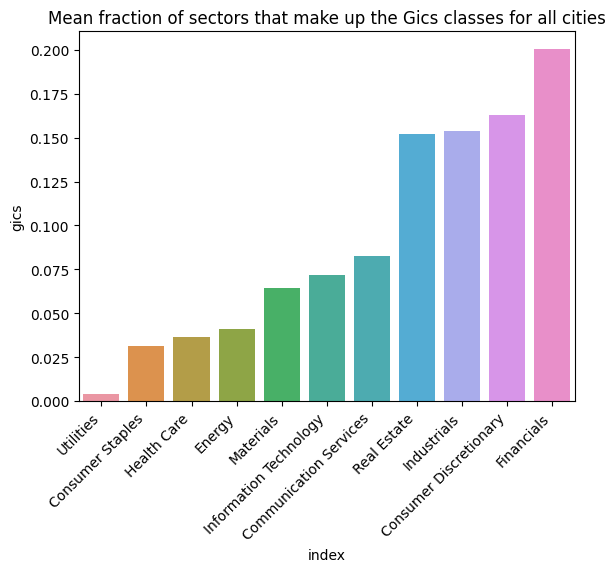

In [124]:
sns.barplot(data = gics_distrib.mean(axis = 0).sort_values().reset_index().rename(columns={0:'gics'}), x = 'index', y = 'gics')
plt.xticks(rotation=45, ha='right', va='top')
plt.title('Mean fraction of sectors that make up the Gics classes for all cities')
plt.show()

/home/jonno/wealthnets/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


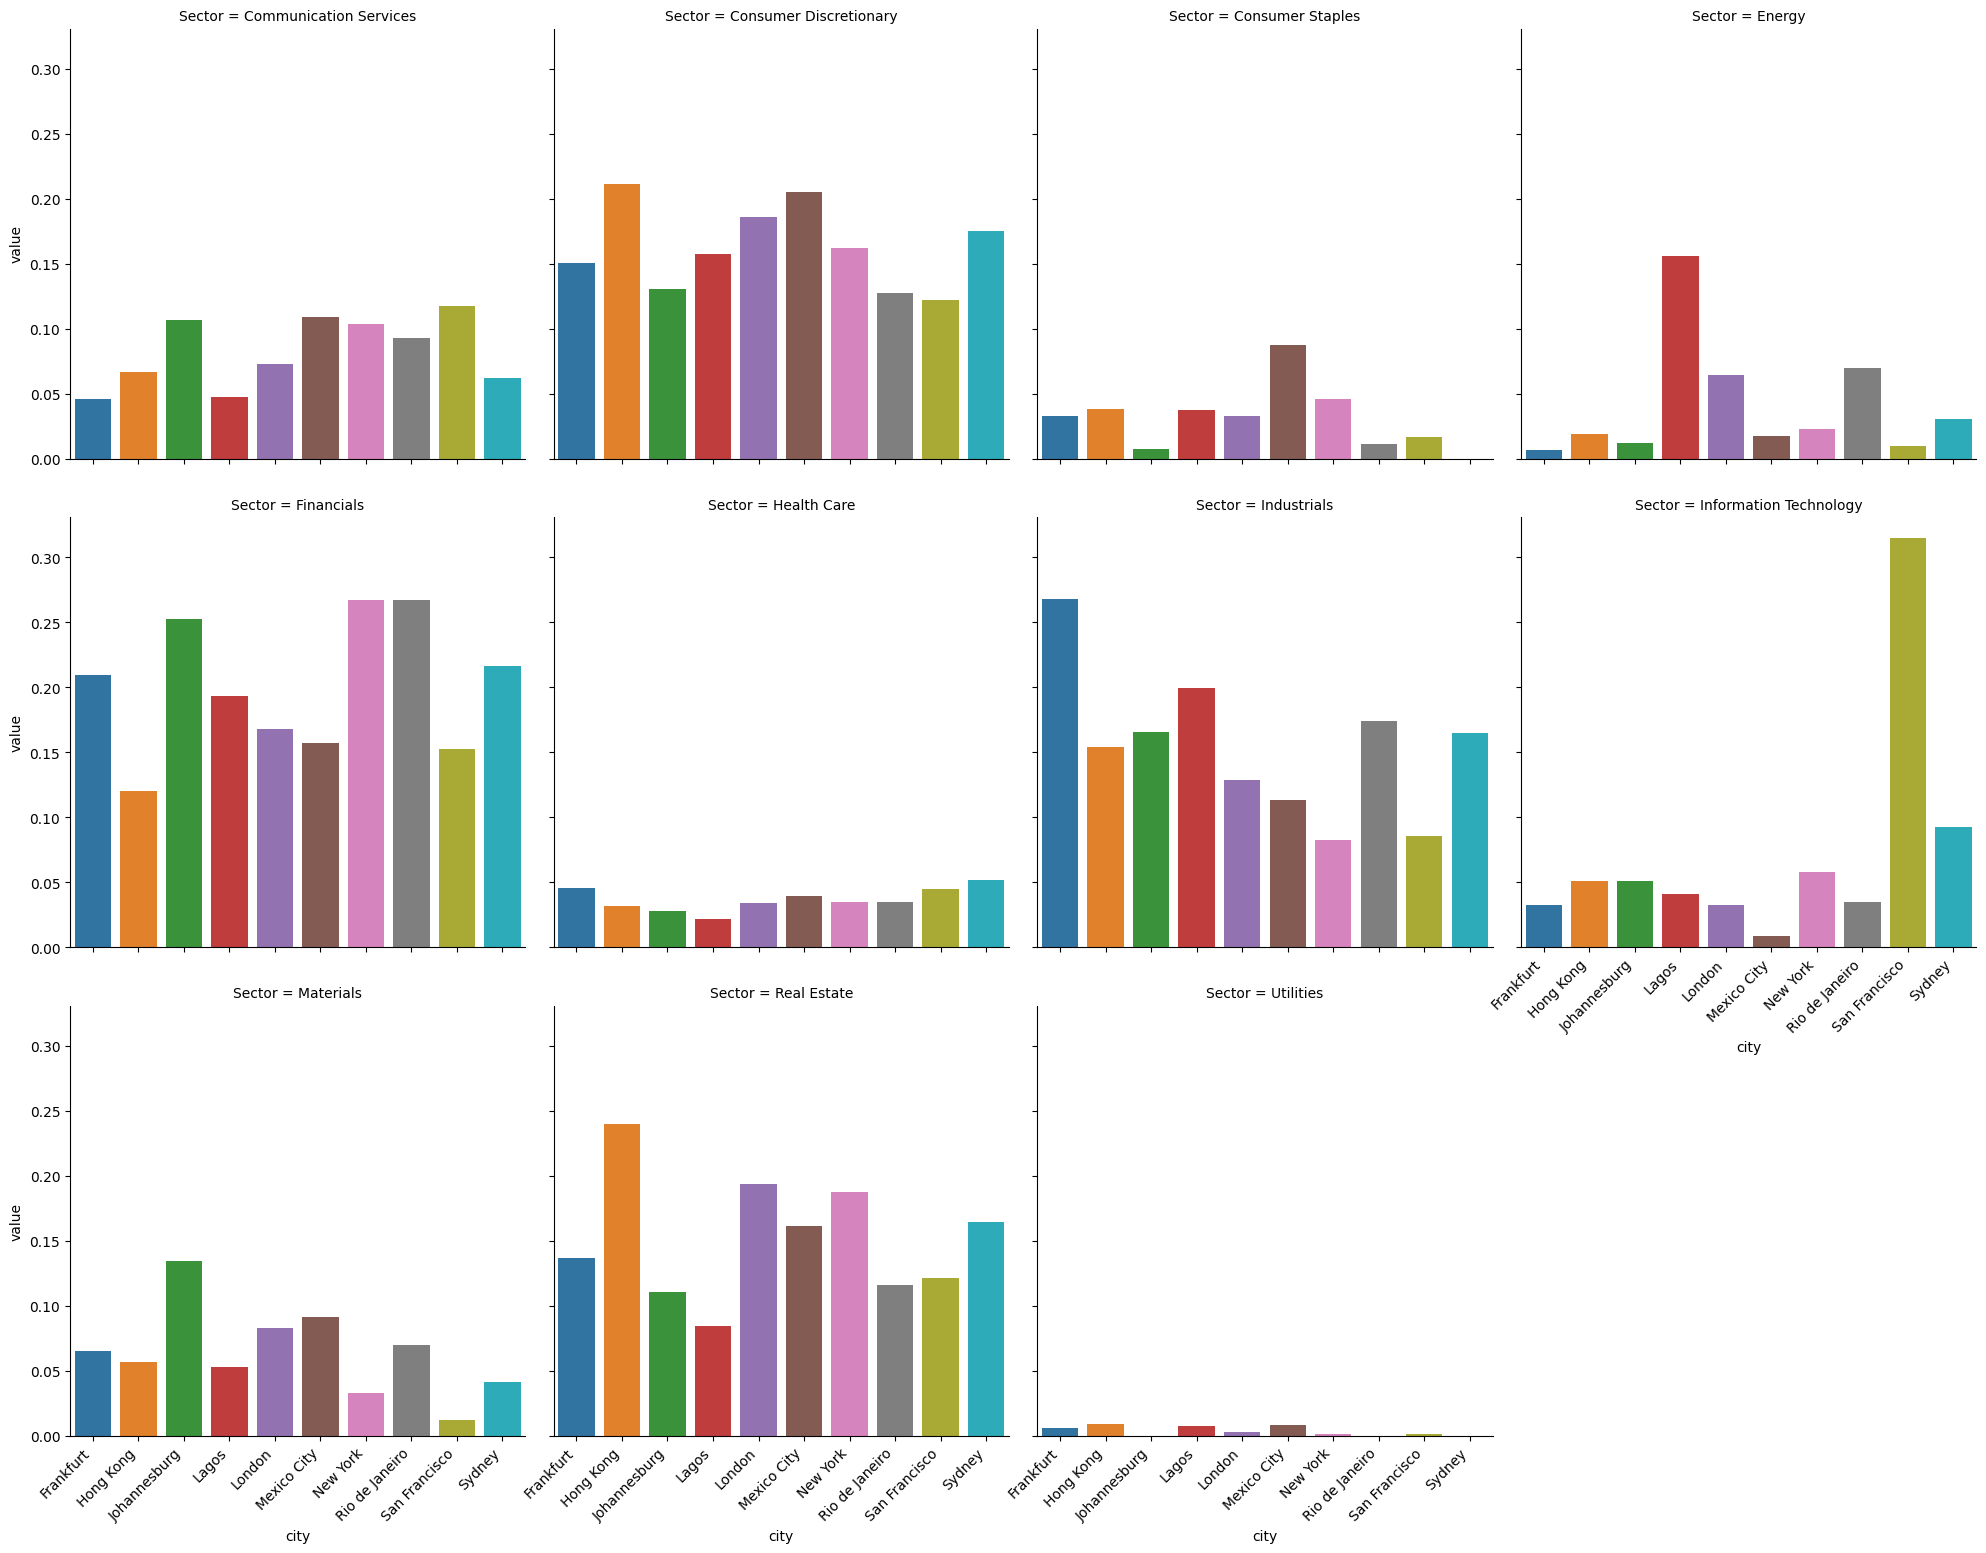

In [152]:
gics_distrib.to_csv('./data/gics_distrib_sector.csv')

g = sns.catplot(data=gics_distrib.reset_index().melt(id_vars=['city'], var_name='Sector'),
             x = 'city', y = 'value', col='Sector', kind='bar', col_wrap=4)

# Draw the plot to ensure tick labels are properly set
plt.draw()

# Rotate x-axis labels for each subplot
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

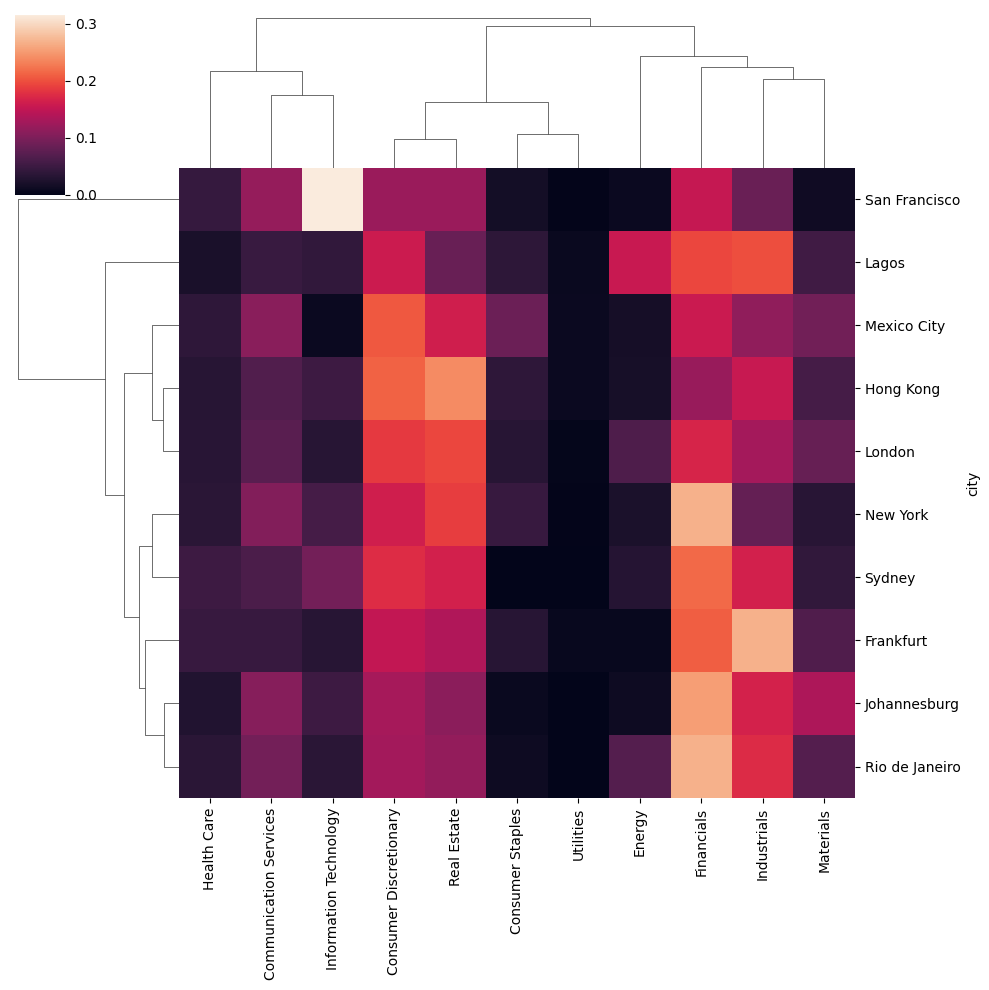

In [149]:
similarity_matrix = cosine_similarity(gics_distrib, gics_distrib )

names = gics_distrib.index

similarity_df = pd.DataFrame(similarity_matrix, index=names, columns=names)


sns.clustermap(gics_distrib, metric = 'correlation')

# Classify ethnicities

In [75]:
data_root = './data/cities_json'
names_path = './data/names_ethnicity.csv'
pattern = r"Wealth-X(.*?)Dossier"

if os.path.exists(names_path):
    # Load the existing CSV if it exists
    names_ethnicity_df = pd.read_csv(names_path)

else:
    # Run the code to generate DataFrames
    names_ethnicity_df = []
    
    for path in os.listdir(data_root):
        full_path = f"{data_root}/{path}"
        all_files = os.listdir(full_path)

        temp_df = pd.DataFrame(all_files, columns=['file'])
        temp_df['city'] = path
        temp_df['file'] = temp_df['file'].str.replace('.pkl', "", regex=False)
        temp_df['name'] = temp_df['file'].str.extract(pattern)
        temp_df['name'] = temp_df['name'].str.lower() 

        names_ethnicity_df.append(temp_df)

    names_ethnicity_df = pd.concat(names_ethnicity_df, ignore_index=True)
    names_ethnicity_df = names_ethnicity_df[['file','city', 'name' ]]
    #names_ethnicity_df['name_city'] = [* zip(names_ethnicity_df['name'], names_ethnicity_df['city'])]
    #names_ethnicity_df['name_city'] = names_ethnicity_df['name_city'].astype(str)
    names_ethnicity_df.to_csv(names_path)

In [60]:
countries_dict = {
    1: "Indian Subcontinent",
    2: "Russia",
    3: "China",
    4: "Anglophone (United States, United Kingdom, Australia, Canada, etc.)",
    5: "Germany",
    6: "Brazil",
    7: "Middle East and North Africa (MENA)",
    8: "Sub-Saharan Africa",
    9: "Latin America (excluding Brazil)",
    10: "East Asia (excluding China)",
    11: "South East Asia",
    12: "Eastern Europe (excluding Russia)",
    13: "Western Europe (excluding Germany and the Anglophone countries)"
}



In [61]:
name_origin_list = [{'name': 'david cameron', 'ethnicity': 4},
 {'name': 'sadiq khan', 'ethnicity': 1},
 {'name': 'sim sang-jung', 'ethnicity': 10},
 {'name': 'goodluck jonathan', 'ethnicity': 8},
 {'name': 'angela merkle', 'ethnicity': 4}]


system_message = f"""You are an expert in the regional origin of names. Read the dictionary of ethnic origin classes (eth_dict) surrounded by triple colons 
:::{countries_dict}:::
    
    now see the example python list of name-origin dictionaries, the names have been paired with the most appropriate ethnic/country origin from the eth_dict
    {name_origin_list}

    The user will supply you with a python dictionary with a name and the city that the people live in. using this information you must reason through the most
    likely ethnic/regional origin of the name from the list, paying particular attention the last name. 
    Construct your response to have the same format as the example json
    
    """

In [57]:
if 'classes' not in names_ethnicity_df.columns:
    names_ethnicity_df = identify_ethnicity_classes(names_ethnicity_df, system_message, rate_limit=80000, save_path='./data/temp_ethnicity_classes.csv')
    names_ethnicity_df.to_csv(names_path, index = False)

Loop number: 2400 | Time per 100 iterations: 0.2002 seconds | Expected finish time: 2023-08-13 22:28:00
Loop number: 2500 | Time per 100 iterations: 1.0600 seconds | Expected finish time: 2023-08-13 22:35:00
RateLimitError encountered: Rate limit reached for default-gpt-3.5-turbo in organization org-PXtP9xMXWP8KqzH24Bz03Cgi on tokens per min. Limit: 90000 / min. Current: 88226 / min. Contact us through our help center at help.openai.com if you continue to have issues., waiting for a minute...
TimeoutError encountered: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600), retrying in 10 seconds...
Loop number: 2600 | Time per 100 iterations: 7.7272 seconds | Expected finish time: 2023-08-13 23:16:00
RateLimitError encountered: Rate limit reached for default-gpt-3.5-turbo in organization org-PXtP9xMXWP8KqzH24Bz03Cgi on tokens per min. Limit: 90000 / min. Current: 87878 / min. Contact us through our help center at help.openai.com if y

In [79]:

names_ethnicity_df['class_codes'] = names_ethnicity_df['classes'].apply(lambda x: ast.literal_eval(x)['ethnicity'])
names_ethnicity_df = names_ethnicity_df.merge(pd.DataFrame(countries_dict.items(), columns=['class_codes', 'class_name']), on='class_codes')



In [106]:
names_ethnicity_df.groupby('city').size()


all_files

,embedded,not_embedded
city,,
Frankfurt,103,229.0
Hong Kong,384,14.0
Johannesburg,124,2.0
Lagos,246,25.0
London,394,6.0
Mexico City,104,3.0
New York,389,11.0
Rio de Janeiro,52,NaN
San Francisco Bay Area,390,9.0


In [151]:
ethnicity_matrix = pd.get_dummies(names_ethnicity_df['class_name'])
ethnicity_matrix['city'] = names_ethnicity_df['city'].str.replace(' Bay Area', "")

eth_totals = ethnicity_matrix.groupby('city').sum()

eth_distrib = eth_totals.div(eth_totals.sum(axis = 1), axis = 0)

eth_distrib.T.to_csv('./data/eth_distrib.csv')

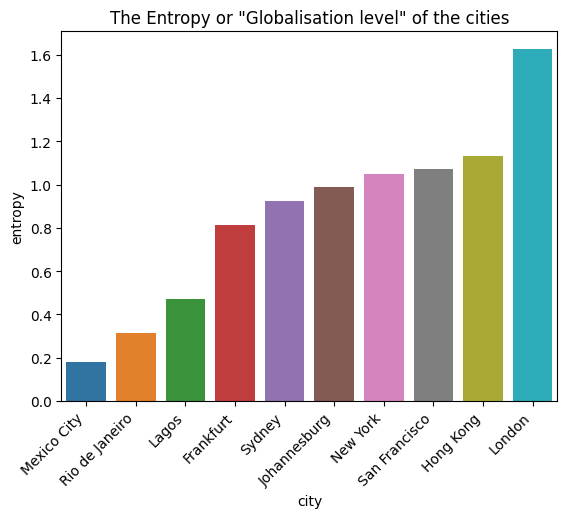

In [64]:


entropy_values = eth_distrib.apply(lambda row: entropy(row), axis=1)
entropy_values =  entropy_values.sort_values().reset_index().rename(columns = {0:'entropy'})

sns.barplot(data = entropy_values, x = 'city', y = 'entropy')
plt.title('The Entropy or "Globalisation level" of the cities')
plt.xticks(rotation=45, ha='right', va='top')
plt.show()
#useful paper on globalisation measures
#https://journals.sagepub.com/doi/full/10.1177/2158244013508417

Text(0.5, 1.0, 'Hierachically clustered heatmap of intr-city ethnic similarity')

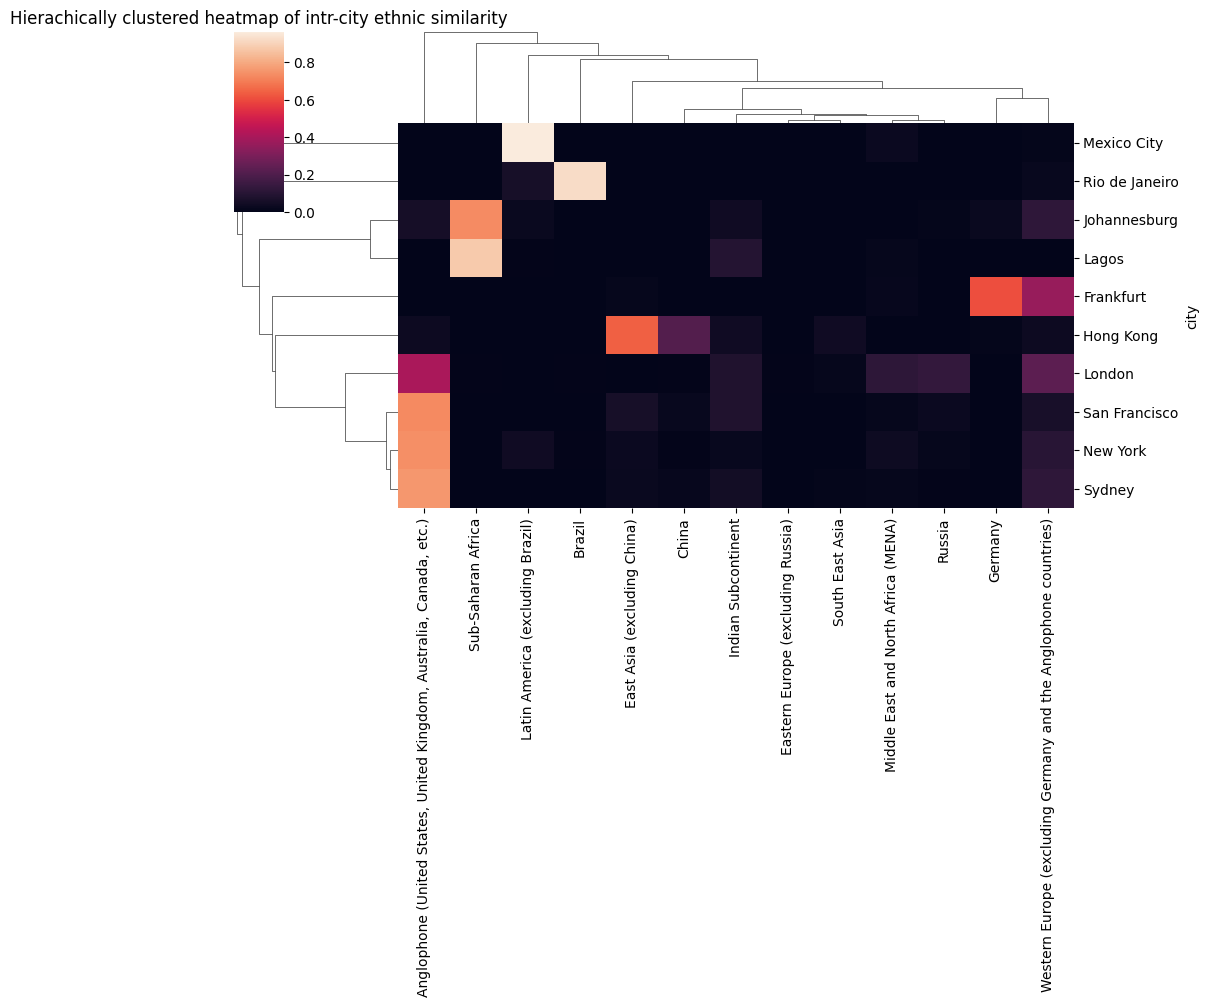

In [150]:


similarity_matrix = cosine_similarity(eth_distrib, eth_distrib )

names = eth_distrib.index

similarity_df = pd.DataFrame(similarity_matrix, index=names, columns=names)

sns.clustermap(eth_distrib)
plt.title('Hierachically clustered heatmap of intr-city ethnic similarity')

# identifying industries using cosine similarity

This didn't work very well due to the non-linear multi-label relationships. However, I am keeping it in for now

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(df_A, df_B):
    # Assuming that the embeddings in both dataframes are stored in a column named 'embeddings'
    embeddings_A = np.stack(df_A['embedding'].values)
    embeddings_B = np.stack(df_B['embedding'].values)
    
    # Calculate cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_A, embeddings_B)
    
    return cosine_sim_matrix


def compute_similarity_statistics(cosine_sim_matrix, min = 0, max = 1, num_cutoffs=1000):
    cutoffs = np.linspace(min, max, num=num_cutoffs)
    
    statistics = {
        'Cutoff': [],
        'Maximum': [],
        'Minimum': [],
        'Mean': [],
        'Median': [],
        'Standard Deviation': []
    }

    for cutoff in cutoffs:
        row_sums = np.sum(cosine_sim_matrix >= cutoff, axis=1)
        if row_sums.any():
            statistics['Cutoff'].append(cutoff)
            statistics['Maximum'].append(np.max(row_sums))
            statistics['Minimum'].append(np.min(row_sums))
            statistics['Mean'].append(np.mean(row_sums))
            statistics['Median'].append(np.median(row_sums))
            statistics['Standard Deviation'].append(np.std(row_sums))

    result_df = pd.DataFrame(statistics)
    return result_df

test = compute_cosine_similarity(all_bios_df, gics_embeddings_df)

test2 = compute_similarity_statistics(test, 0.7, 0.73, num_cutoffs=1000)
test2.loc[test2['Minimum']==1].sort_values('Cutoff', ascending=False).head()

sns.lineplot(data = test2, x = 'Cutoff', y = 'Minimum')